## Import the necessary header files required

Check whether you have GPU availablity since training in CPU is very slow

Prerequisites: 
* Knows intermediate python
* Classification problems in machine learning
* How **Forward prop** and **Back prop** works in neural nets
* Basics of gradient descent (also nice to know kinds of parameter updates)

In [1]:
import torch
import torch.nn as nn                   #for sequence api in torch
from torch.utils.data import DataLoader #for loading images
import numpy as np                      #just in case if you need numpy arrays
import torchvision.transforms as T      #Used for data preprocessing and converting images to tensors
import torchvision.datasets as dset
import torch.optim as optim             #For using the desired parameter update
import torch.nn.functional as F

USE_GPU = True

if USE_GPU and torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

dtype = torch.float32

print("Using device: ",device)

Using device:  cuda


## Data loading and preprocessing

Here there isn't much of data preprocessing going on, The RandomHorizontalFlip flips images randomly so our model is more robust

The DataLoader part in Pytorch takes care of target labels(y, which in our case is the name of the folder) and features(x)

In [2]:
transform = T.Compose([T.RandomHorizontalFlip(),T.ToTensor()])
#Training 
train_data = dset.ImageFolder("../input/face-expression-recognition-dataset/images/train",transform=transform)
loaded_train = DataLoader(train_data,batch_size=64,shuffle=True)
#Validation
validation_data = dset.ImageFolder("../input/face-expression-recognition-dataset/images/validation",transform=transform)
loaded_validation = DataLoader(validation_data,batch_size=64,shuffle=False)

loss_history = []
validation_acc = []
training_acc = []

## Visualizing the image

As a usual gut check it's recommended to see your image to be sure that image appears properly from DataLoader

Here I've implemented a random way of selecting a expression from the list of images

Target label:  angry


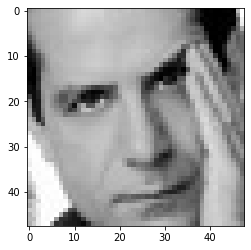

In [3]:
%matplotlib inline              
import matplotlib.pyplot as plt
import random                   #For selecting random element from list

dataiter = iter(loaded_train)   #The iter() function in python represents the iterator similar to c++ iterators
images, labels = dataiter.next() #The next() method retrieves the object 
expression = {0:"angry",1:"disgust",2:"fear",3:"happy",4:"neutral",5:"sad",6:"surprise"} #Create a dictionary for mapping accordingly
random_idx = random.sample(range(0,64),1)[0]     #Selects a random single number from 0-64
print("Target label: ",expression[int(labels[random_idx].numpy())])  #Converting it to numpy from tensor to fetch the label
plt.imshow(np.transpose(images[random_idx].numpy(), (1, 2, 0)))   

## Creating a method for predicting validation accuracy

*In Pytorch, we don't have any api like model.fit() in tensorflow, so we have to create our own method.*

* The function calculates the number of correct samples and divides by the number of total samples which ultimately gives us the accuracy.
* Notice torch.no_grad() part, this is very important as we don't want to back-propagate while predicting.

In [4]:
def check_accuracy_part(loader, model):
    print('Checking accuracy on validation set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

## Training the model

* This method trains our model and it's almost similar to the accuracy part.
* Here we have backward() - takes care of back propagation and the optimizer - takes care of parameter update

In [5]:
def train_part(model, optimizer, epochs=1):
    """
    Train a model using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print("epoch: ",e+1)
        for t, (x, y) in enumerate(loaded_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % 100 == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part(loaded_validation, model)
                print()

## Building our neural network

This is completely upto your choice you can prefer any kind of structure that you want.

*In torch make sure your conv and pool dimensions are proper* or else the matrices/tensors can't undergo proper matrix multipilcation.

***Remember to flatten for shifting from convolutional layers to fully connected layers***

The ReduceLROnPlateau reduces the learning rate whenever our network is stuck at a local minima.

### Important formulas for calculating dimensions

* Output of conv layer would have dimension -> ((H - F + 2P)//s) + 1 *we can't have decimals here*

  *where H - height of input(in our case image) , F - kernel_size(filter size) , P - padding & s - stride (vice versa for width)* 
  
  
* If you want the input dimensions (height & width) to remain same then you can use this -> (F - 1)/2

  *where F - kernel_size(filter size)*

In [6]:
model = None
optimizer = None

#First architecture #3,32,32
conv1 = nn.Sequential(
    nn.Conv2d(3,512,kernel_size=(3,3),bias=True,padding=1), #512,48,48
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2))  #Sampling image to half  512,24,24
)
conv2 = nn.Sequential(
    nn.Conv2d(512,128,kernel_size=(3,3),padding=1,bias=True), #128,24,24
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2))         #128,12,12
)
conv3 = nn.Sequential(
    nn.Conv2d(128,64,kernel_size=(3,3),bias=True,padding=1), #64,12,12
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2))   #64,6,6
)
conv4 = nn.Sequential(
    nn.Conv2d(64,256,kernel_size=(3,3),bias=True,padding=1), #64,6,6
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2))   #256,3,3
)
fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(256*3*3,7),
)
model = nn.Sequential(
    conv1,
    conv2,
    conv3,
    conv4,
    fc
)
learning_rate=0.001
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
train_part(model, optimizer, epochs=10)

epoch:  1
Iteration 0, loss = 2.0171
Checking accuracy on validation set
Got 1023 / 7066 correct (14.48)

Iteration 100, loss = 1.6580
Checking accuracy on validation set
Got 2327 / 7066 correct (32.93)

Iteration 200, loss = 1.5900
Checking accuracy on validation set
Got 2927 / 7066 correct (41.42)

Iteration 300, loss = 1.5431
Checking accuracy on validation set
Got 2983 / 7066 correct (42.22)

Iteration 400, loss = 1.2747
Checking accuracy on validation set
Got 3313 / 7066 correct (46.89)

epoch:  2
Iteration 0, loss = 1.1730
Checking accuracy on validation set
Got 3424 / 7066 correct (48.46)

Iteration 100, loss = 1.3153
Checking accuracy on validation set
Got 2940 / 7066 correct (41.61)

Iteration 200, loss = 1.1501
Checking accuracy on validation set
Got 3501 / 7066 correct (49.55)

Iteration 300, loss = 1.1677
Checking accuracy on validation set
Got 3342 / 7066 correct (47.30)

Iteration 400, loss = 1.1153
Checking accuracy on validation set
Got 3701 / 7066 correct (52.38)

epoc

## Best performance:

In [7]:
#Best model
best_model = model
check_accuracy_part(loaded_validation,best_model)

Checking accuracy on validation set
Got 4325 / 7066 correct (61.21)


## Testing our model with sample images:

Here we'll import random photos from the internet and test how the model predicts

Predicted label:  sad
Correct label:  surprise


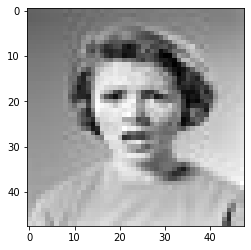

In [8]:
def check_accuracy_test(x,y,model):
  num_samples = 0
  num_correct = 0
  loss = None
  model.eval()    #turning drop-out/batch norm layer from training to test mode 
  with torch.no_grad():
    x = x.to(device=device,dtype=dtype)
    y = y.to(device=device,dtype=torch.long)
    scores = model(x)
    _,preds = scores.max(1)
    return preds

expression = {0:"angry",1:"fear",2:"happy",3:"sad",4:"surprise"} #Create a dictionary for mapping accordingly

transform = T.Compose([T.ToTensor()])
test_data = dset.ImageFolder("../input/test-images/test",transform=transform)
loaded_test = DataLoader(test_data,batch_size=5,shuffle=False)

dataiter = iter(loaded_test)   #The iter() function in python represents the iterator similar to c++ iterators
images, labels = dataiter.next() #The next() method retrieves the object

random_idx = random.sample(range(0,5),1)[0] 

image = torch.reshape(images[random_idx],(1,3,48,48))
predicted_idx = check_accuracy_test(image,labels[random_idx],best_model)

print("Predicted label: ",expression[predicted_idx.item()]) 
print("Correct label: ",expression[int(labels[random_idx].numpy())])  #Converting it to numpy from tensor to fetch the label
image = torch.reshape(image,(3,48,48))
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))  

### If you find this notebook informative please upvote